In [4]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import Libraries
import pandas_datareader as web
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import math
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
# machile learning
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# load password
from config import db_password

# Assign connection values
url = "finalproject.crrfdeawjuaz.us-east-1.rds.amazonaws.com"
port = "5432"
db_name = "tesla"

In [3]:
# Connect to the AWS database
from sqlalchemy import create_engine
db_string = f"postgresql://postgres:{db_password}@{url}:{port}/{db_name}"
engine = create_engine(db_string)
conn = engine.connect()

In [6]:
# read table daily values
df1 = pd.read_sql('SELECT * FROM "daily_values"', conn)
print(df1.shape)
df1.head()

(2821, 9)


,ticker,hdate,hopen,hhigh,hlow,hclose,hadjclose,hvolume,q_key
0,TSLA,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,None
1,TSLA,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,2010Q2
2,TSLA,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,None
3,TSLA,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,None
4,TSLA,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,None


In [8]:
# Reindex data using a DatetimeIndex
df2 = df1
df1_series = pd.to_datetime(df1['hdate'])
df1_index = pd.DatetimeIndex(df1_series.values)
df3 = df2.set_index(df1_index)
df3.drop('hdate', axis=1, inplace=True)
print(df3.shape)
df3

(2821, 8)


,ticker,hopen,hhigh,hlow,hclose,hadjclose,hvolume,q_key
2010-06-29,TSLA,3.800,5.000,3.508,4.778,4.778,93831500,None
2010-06-30,TSLA,5.158,6.084,4.660,4.766,4.766,85935500,2010Q2
2010-07-01,TSLA,5.000,5.184,4.054,4.392,4.392,41094000,None
2010-07-02,TSLA,4.600,4.620,3.742,3.840,3.840,25699000,None
2010-07-06,TSLA,4.000,4.000,3.166,3.222,3.222,34334500,None
...,...,...,...,...,...,...,...,...
2021-09-03,TSLA,732.250,734.000,724.200,733.570,733.570,15246100,None
2021-09-07,TSLA,740.000,760.200,739.260,752.920,752.920,20039800,None
2021-09-08,TSLA,761.580,764.450,740.770,753.870,753.870,18793000,None
2021-09-09,TSLA,753.410,762.100,751.630,754.860,754.860,14077700,None


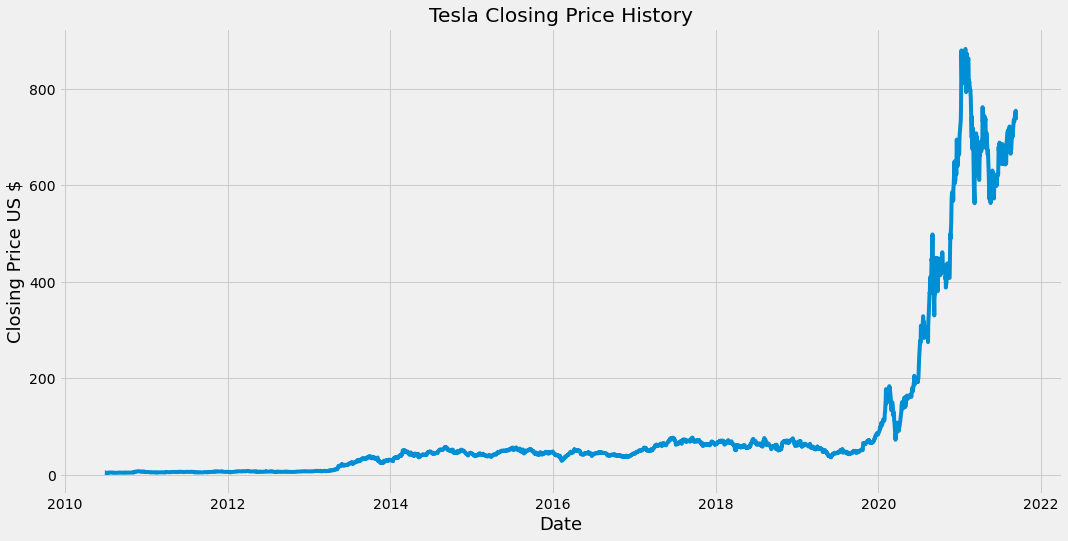

In [9]:
#Visualize closing price history for data range
plt.figure(figsize=(16,8))
plt.title('Tesla Closing Price History')
plt.plot(df3['hclose'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price US $', fontsize=18)
plt.show()

In [13]:
# New Dataframe for just the close price column
data = df3.filter(['hclose'])
#Convert it to a numpy array
dataset = data.values

print(dataset.shape)
dataset

(2821, 1)


array([[  4.778],
       [  4.766],
       [  4.392],
       ...,
       [753.87 ],
       [754.86 ],
       [736.27 ]])

In [14]:
#get the number of rows to train the model on -> 80%
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

2257

In [15]:
# Scale the data - preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(len(scaled_data))
scaled_data


2821


array([[0.00183878],
       [0.00182515],
       [0.00140011],
       ...,
       [0.85314741],
       [0.8542725 ],
       [0.83314582]])

In [16]:
# print(len(train_data))
print(training_data_len)

2257


In [17]:
# Create the training dataset
train_data = scaled_data[0:training_data_len , :]
# Split the data
x_train = [] # features
y_train = [] # dependent variables

for i in range(365, len(train_data)):
    x_train.append(train_data[i-365:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 365:
        print(x_train)
        print(y_train)
        print()

[array([1.83878263e-03, 1.82514518e-03, 1.40011137e-03, 7.72788745e-04,
       7.04601502e-05, 0.00000000e+00, 3.77302740e-04, 3.63665292e-04,
       2.84113509e-04, 5.31860489e-04, 9.18254861e-04, 9.29619402e-04,
       1.10008751e-03, 1.38874683e-03, 1.02280863e-03, 1.00462537e-03,
       1.18191220e-03, 1.24782653e-03, 1.17054766e-03, 1.07963133e-03,
       1.11827077e-03, 1.03417317e-03, 9.40983942e-04, 1.16372893e-03,
       1.39783846e-03, 1.24100781e-03, 1.05690225e-03, 8.61432159e-04,
       8.63705067e-04, 7.34149307e-04, 4.77310695e-04, 4.09123453e-04,
       5.72772834e-04, 6.77326606e-04, 7.61424204e-04, 6.75053697e-04,
       6.79599514e-04, 7.50059664e-04, 9.84169195e-04, 7.72788745e-04,
       9.31892310e-04, 8.97798689e-04, 8.86434148e-04, 9.25073585e-04,
       8.36430171e-04, 1.05690225e-03, 1.19554965e-03, 1.19327674e-03,
       1.07735843e-03, 1.15918312e-03, 1.11599786e-03, 9.93260828e-04,
       1.11827077e-03, 1.20918709e-03, 1.40465719e-03, 1.16827475e-03,
     

In [18]:
# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
x_train.shape

(1892, 365)

In [20]:
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1892, 365, 1)

In [21]:
#build LSTM model 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [22]:
#compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1892/1892 [==============================] - 318s 165ms/step - loss: 4.1683e-05


In [24]:
# Create the testing dataset
# Create a new array from 2014-2517
test_data = scaled_data[training_data_len - 365: , :]

# Create test data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(365, len(test_data)):
    x_test.append(test_data[i-365:i, 0])
    

In [25]:
#Convert data to numpy array
x_test = np.array(x_test)

In [26]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
# Get the Model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [37]:
# Get root mean squared error (RMSE)
# Use other evaluation methods to confirm how good the model is
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 82.7586033081704


In [29]:
#Plot data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


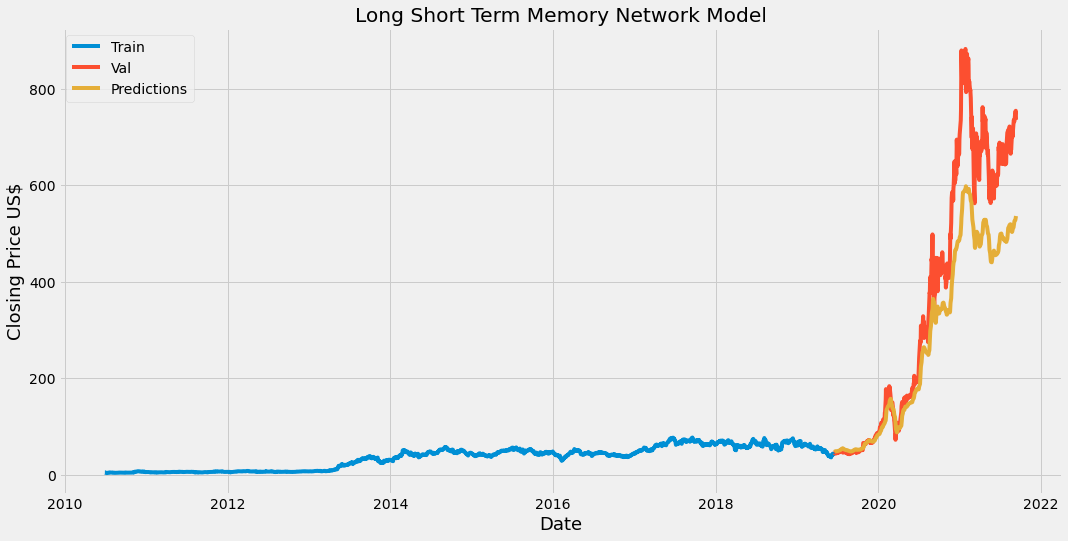

In [34]:
#Visualize
plt.figure(figsize=(16,8))
plt.title('Long Short Term Memory Network Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price US$', fontsize=18)
plt.plot(train['hclose'])
plt.plot(valid[['hclose', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')


In [32]:
# Show the valid vs predicted prices
valid

,hclose,Predictions
2019-06-18,44.948,47.129501
2019-06-19,45.286,47.630993
2019-06-20,43.924,48.106541
2019-06-21,44.372,48.364769
2019-06-24,44.728,48.524300
...,...,...
2021-09-03,733.570,526.216919
2021-09-07,752.920,528.050537
2021-09-08,753.870,530.889038
2021-09-09,754.860,533.830505


In [33]:
# get the quote
tesla_quote = web.DataReader('TSLA', data_source='yahoo', start='2011-01-01', end='2021-09-15')

In [35]:
# New dataframe
new_df = tesla_quote.filter(['Close'])

#Get the last 365 days closing price values
last_365_days = new_df[-365:].values

# Scale the data
last_365_days_scaled = scaler.transform(last_365_days)

#Create empty list
X_test = []

# Append the last 365 days
X_test.append(last_365_days_scaled)

#Convert the X_test data to a numpy array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[537.56506]]


In [36]:
# get the quote for a given future date
tesla_quote2 = web.DataReader('TSLA', data_source='yahoo', start='2021-09-16', end='2023-09-16')
print(tesla_quote2)

                  High         Low        Open      Close    Volume  Adj Close
Date                                                                          
2021-09-16  758.909973  747.609985  752.830017  756.98999  13923400  756.98999
2021-09-17  761.039978  750.000000  757.150024  759.48999  28186100  759.48999
